<a href="https://colab.research.google.com/github/jduell12/DS-Unit-2-Kaggle-Challenge/blob/main/C_LS_DS_222_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 2*

---

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/main/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Module Project: Random Forests

This week, the module projects will focus on creating and improving a model for the Tanazania Water Pump datset. Your goal is to create a model to predict whether a water pump is functional, non-functional, or needs repair.

Dataset source: [DrivenData.org](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/).

## Directions

The tasks for this project are as follows:

- **Task 1:** Sign up for a [Kaggle](https://www.kaggle.com/) account.
- **Task 2:** Use `wrangle` function to import training and test data.
- **Task 3:** Split training data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and test sets.
- **Task 5:** Establish the baseline accuracy score for your dataset.
- **Task 6:** Build and train `model_dt`.
- **Task 7:** Calculate the training and validation accuracy score for your model.
- **Task 8:** Adjust model's `max_depth` to reduce overfitting.
- **Task 9 `stretch goal`:** Create a horizontal bar chart showing the 10 most important features for your model.

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `pandas-profiling`
- `sklearn`

# I. Wrangle Data

In [3]:
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [18]:
def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path, 
                                  na_values=[0, -2.000000e-08], parse_dates=['date_recorded']),
                      pd.read_csv(tv_path)).set_index('id')
    else:
        df = pd.read_csv(fm_path, 
                         na_values=[0, -2.000000e-08],parse_dates=['date_recorded'],
                         index_col='id')

    # Drop constant columns
    df.drop(columns=['recorded_by'], inplace=True)

    # create age feature
    df['pump_age'] = df['date_recorded'].dt.year - df['construction_year']
    df.drop(columns=['date_recorded'], inplace=True)

    # Drop HCCCs
    cutoff = 100
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)

    # Drop duplicate columns
    dupe_cols = [col for col in df.head(15).T.duplicated().index
                 if df.head(15).T.duplicated()[col]]
    df.drop(columns=dupe_cols, inplace=True)             

    return df

**Task 1:** Sign up for a [Kaggle](https://www.kaggle.com/) account. Choose a username that's based on your real name. Like GitHub, Kaggle is part of your public profile as a data scientist.

**Task 2:** Modify the `wrangle` function to engineer a `'pump_age'` feature. Then use the function to read `train_features.csv` and `train_labels.csv` into the DataFrame `df`, and `test_features.csv` into the DataFrame `X_test`.

In [19]:
df = wrangle(DATA_PATH + 'waterpumps/train_features.csv', DATA_PATH + 'waterpumps/train_labels.csv')
X_test = wrangle(DATA_PATH + 'waterpumps/test_features.csv')

# II. Split Data

**Task 3:** Split your DataFrame `df` into a feature matrix `X` and the target vector `y`. You want to predict `'status_group'`.

In [20]:
target = 'status_group'
X = df.drop(columns=target)
y = df[target]

**Task 4:** Using a randomized split, divide `X` and `y` into a training set (`X_train`, `y_train`) and a validation set (`X_val`, `y_val`).

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# III. Establish Baseline

**Task 5:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents.

In [22]:
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.5425829668132747


# IV. Build Model

**Task 6:** Build a `Pipeline` named `model_rf`, and fit it to your training data. Your `Pipeline` should include:

- an `OrdinalEncoder` transformer for categorical features.
- a `SimpleImputer` transformer fot missing values.
- a `RandomForestClassifier` predictor.

**Note:** Don't forget to set the `random_state` parameter for your `RandomForestClassifier`. Also, to decrease training time, set `n_jobs` to `-1`.

In [57]:
model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=30, max_depth=20)
)


In [58]:
model_rf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type',
                                      'waterpoint_type_group...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=20, max_features='auto',
                                   

# V. Check Metrics

**Task 7:** Calculate the training and validation accuracy scores for `model_rf`.

In [59]:
training_acc = model_rf.score(X_train, y_train)
val_acc = model_rf.score(X_val, y_val)

print('Training Accuracy Score:', training_acc) # 1st - 99.52, 2nd (n_estimators) - 99.27, 3rd (depth) - 94.28
print('Validation Accuracy Score:', val_acc) #1st- 80.22, 2nd (n_estimators)- 80.25, 3rd (depth) - 80.63

Training Accuracy Score: 0.9412866432374418
Validation Accuracy Score: 0.8063131313131313


# VI. Tune Model

**Task 8:** Tune `n_estimators` and `max_depth` hyperparameters for your `RandomForestClassifier` to get the best validation accuracy score for `model_rf`. 

In [32]:
# Use this cell to experiment and then change 
# your model hyperparameters in Task 6
model_rf.named_steps['randomforestclassifier'].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [35]:
estimators = range(2, 100, 2)
train_acc = []
val_acc = []

for est in estimators:
  model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=est)
  ) 
  model_rf.fit(X_train, y_train)
  train_acc.append(model_rf.score(X_train, y_train))
  val_acc.append(model_rf.score(X_val, y_val))

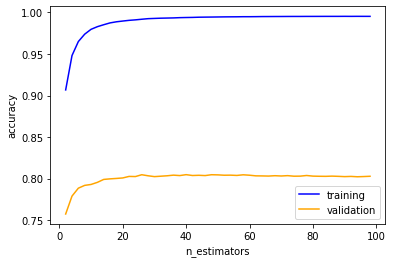

In [37]:
plt.plot(estimators, train_acc, color='blue', label='training');
plt.plot(estimators, val_acc, color='orange', label='validation');
plt.xlabel('n_estimators');
plt.ylabel('accuracy')
plt.legend();

In [46]:
depths = range(2, 38, 2)

train_acc2 = []
val_acc2 = []

for depth in depths:
  model_rf = make_pipeline(OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=depth))
  
  model_rf.fit(X_train, y_train)
  train_acc2.append(model_rf.score(X_train, y_train))
  val_acc2.append(model_rf.score(X_val, y_val))

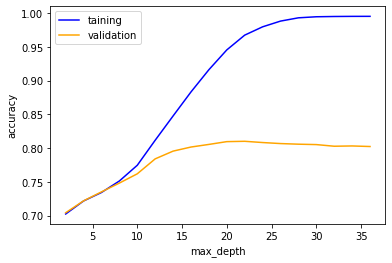

In [47]:
plt.plot(depths, train_acc2, color='blue', label='taining')
plt.plot(depths, val_acc2, color='orange', label='validation')

plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend();

# VII. Communicate Results

**Task 9:** Generate a list of predictions for `X_test`. The list should be named `y_pred`.

In [64]:
y_pred = model_rf.predict(X_test)

assert len(y_pred) == len(X_test), f'Your list of predictions should have {len(X_test)} items in it. '

**Task 11 `stretch goal`:** Create a DataFrame `submission` whose index is the same as `X_test` and that has one column `'status_group'` with your predictions. Next, save this DataFrame as a CSV file and upload your submissions to our competition site. 

**Note:** Check the `sample_submission.csv` file on the competition website to make sure your submissions follows the same formatting. 

In [74]:
submission = pd.DataFrame(data=y_pred, index=X_test.index, columns=['status_group'])
submission.head()

,status_group
id,
50785,non functional
51630,functional
17168,functional
45559,non functional
49871,functional


In [72]:
X_test.index

Int64Index([50785, 51630, 17168, 45559, 49871, 52449, 24806, 28965, 36301,
            54122,
            ...
            59757, 64579, 57731, 65541, 68174, 39307, 18990, 28749, 33492,
            68707],
           dtype='int64', name='id', length=14358)

In [73]:
X_test.head()

,amount_tsh,gps_height,longitude,latitude,num_private,basin,region,region_code,district_code,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,pump_age
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
50785,NaN,1996.0,35.290799,-4.059696,NaN,Internal,Manyara,21,3.0,321.0,True,Parastatal,True,2012.0,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,1.0
51630,NaN,1569.0,36.656709,-3.309214,NaN,Pangani,Arusha,2,2.0,300.0,True,VWC,True,2000.0,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,13.0
17168,NaN,1567.0,34.767863,-5.004344,NaN,Internal,Singida,13,2.0,500.0,True,VWC,NaN,2010.0,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other,3.0
45559,NaN,267.0,38.058046,-9.418672,NaN,Ruvuma / Southern Coast,Lindi,80,43.0,250.0,NaN,VWC,True,1987.0,other,other,vwc,user-group,unknown,unknown,soft,good,dry,shallow well,shallow well,groundwater,other,other,26.0
49871,500.0,1260.0,35.006123,-10.950412,NaN,Ruvuma / Southern Coast,Ruvuma,10,3.0,60.0,NaN,Water Board,True,2000.0,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,13.0
